In [ ]:
import re    
import nltk  
import string 
import warnings 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore")




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',encoding='latin-1')
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
data.columns = DATASET_COLUMNS
data.head()

,target,ids,date,flag,user,TweetText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:

data.drop(['ids','date','flag','user'],axis = 1,inplace = True)

In [ ]:
data.head()

,target,TweetText
0,0,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,@Kwesidei not the whole crew


In [ ]:
positif_data = data[data.target==4].iloc[:25000,:]
print(positif_data.shape)
negative_data = data[data.target==0].iloc[:1000,:]
print(negative_data.shape)

(25000, 2)
(1000, 2)


In [ ]:
tweet_df = pd.concat([positif_data,negative_data],axis = 0)
print(tweet_df.shape)
tweet_df.head()

(26000, 2)


,target,TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! Cant wait!! - GIRL TALK!!
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart."
800002,4,"Being sick can be really cheap when it hurts too much to eat real food Plus, your friends make you soup"
800003,4,@LovesBrooklyn2 he has that effect on everyone


# Data Cleaning

In [ ]:

100*tweet_df.isna().sum()/len(tweet_df)

target       0.0
TweetText    0.0
dtype: float64

In [ ]:
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Clean Tweets

In [ ]:
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

In [ ]:
from nltk.stem.porter import PorterStemmer
def cleanup_tweets(tweet_df):
    
    tweet_df['clean_tweet'] = tweet_df['TweetText'].str.replace("@", "") 
    
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].str.replace(r"http\S+", "") 
    
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].str.replace("[^a-zA-Z]", " ") 
    
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda text : remove_stopwords(text.lower()))
    
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: x.split())
    
    stemmer = PorterStemmer()
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: [stemmer.stem(i) for i in x])
    
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: ' '.join([w for w in x]))
    
    tweet_df['clean_tweet'] = tweet_df['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
cleanup_tweets(tweet_df)

# EDA

In [ ]:

from wordcloud import WordCloud,STOPWORDS
def createWrdCloudForSentiment(target):
    temp_df = pd.DataFrame() 
    if target == -1:
        temp_df = tweet_df
    else:
        temp_df = tweet_df[tweet_df.target==target]
    words = " ".join(temp_df.clean_tweet)
    wrdcld = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1500,
                      height=1000).generate(words)
    plt.figure(figsize=(10,10))
    plt.imshow(wrdcld)
    plt.axis('off')
    plt.show

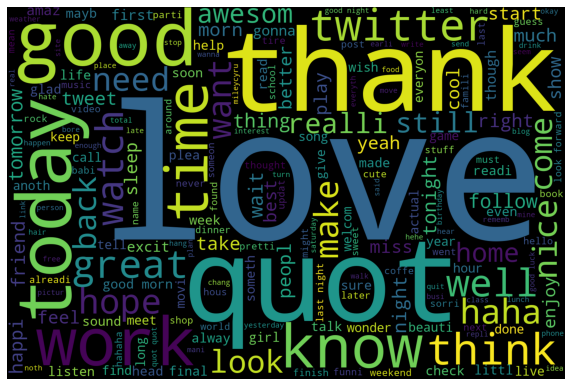

In [ ]:
createWrdCloudForSentiment(-1)

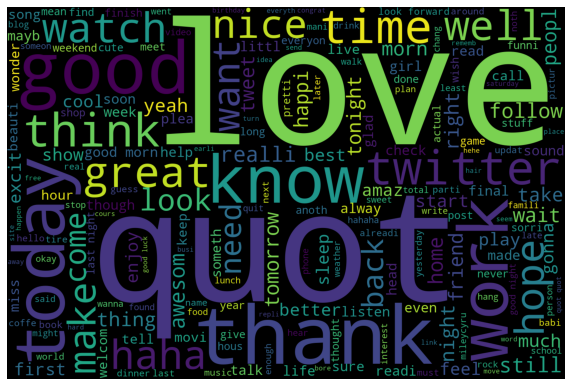

In [ ]:

createWrdCloudForSentiment(4) 


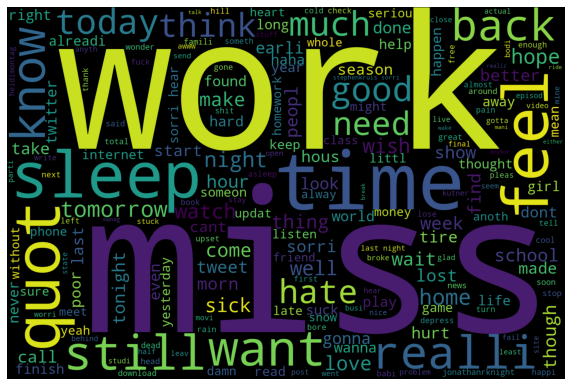

In [ ]:

createWrdCloudForSentiment(0) 

In [ ]:

def createPieChartFor(t_df):
    Lst = 100*t_df.value_counts()/len(t_df)
    
    
    labels = t_df.value_counts().index.values
    sizes =  Lst 
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
    ax1.axis('equal')  
    plt.show()

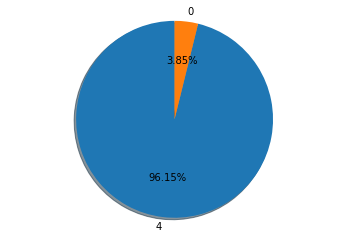

In [ ]:
createPieChartFor(tweet_df.target)

# Model Training

### Make test-train split

In [ ]:

train_df, test_df = train_test_split(tweet_df, test_size=0.3, random_state=42)

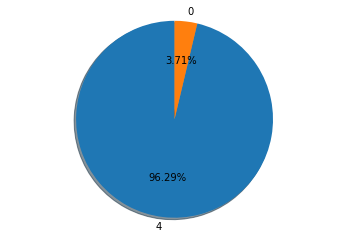

In [ ]:
createPieChartFor(train_df.target)

In [ ]:
train_tweets =[]
for tweet in train_df.clean_tweet:
    train_tweets.append(tweet)
    
test_tweets =[]
for tweet in test_df.clean_tweet:
    test_tweets.append(tweet)

In [ ]:
train_tweets[:10]

['janiceros brodi friend',
 'noth',
 'ride plan nation park chuck coffe good compani cream like heaven',
 'lazygiraff would thing imagin much',
 'macaroniqu hehe till week',
 'thing need work',
 'bloc parti foal london import peopl whole world happi fuck',
 'makoto dinner comedi club soooo freak excit',
 'cyclepath sound good time sleep goodnight',
 'apart tune anyon recommend good reason download site quot legitim quot']

## TF-IDF

In [ ]:

vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_tweets)
test_tfidf_model = vectorizer.transform(test_tweets)

In [ ]:

train_tfidf = pd.DataFrame(train_tfidf_model.toarray(), columns=vectorizer.get_feature_names())


In [ ]:
cls = [LogisticRegression(),
       MultinomialNB(), 
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=1000, random_state=42),
       KNeighborsClassifier(n_neighbors = 5),
       XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3),
       AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=100),
       svm.SVC()]

cls_name = ["LogisticRegression","MultinomialNB","DecisionTreeClassifier","RandomForestClassifier","KNeighborsClassifier","XGBClassifier","AdaBoostClassifier","Support Vector Machine"]

LogisticRegression  Accuracy Score : 95.79%
              precision    recall  f1-score   support

           0       0.00      0.17      0.01         6
           4       1.00      0.96      0.98      7794

    accuracy                           0.96      7800
   macro avg       0.50      0.56      0.49      7800
weighted avg       1.00      0.96      0.98      7800



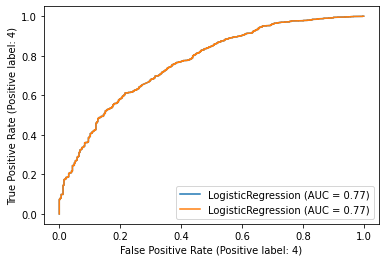

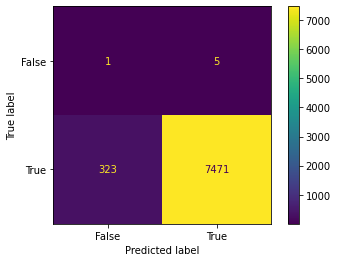

MultinomialNB  Accuracy Score : 95.85%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           4       1.00      0.96      0.98      7800

    accuracy                           0.96      7800
   macro avg       0.50      0.48      0.49      7800
weighted avg       1.00      0.96      0.98      7800



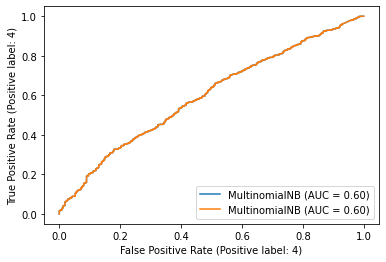

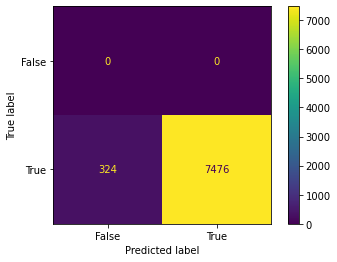

DecisionTreeClassifier  Accuracy Score : 93.92%
              precision    recall  f1-score   support

           0       0.09      0.14      0.11       210
           4       0.98      0.96      0.97      7590

    accuracy                           0.94      7800
   macro avg       0.53      0.55      0.54      7800
weighted avg       0.95      0.94      0.95      7800



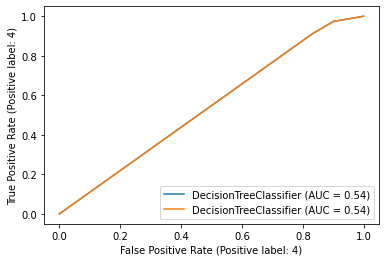

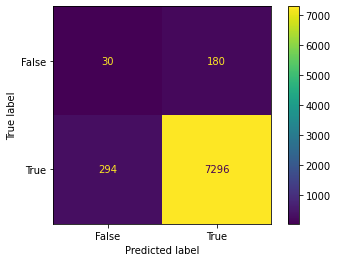

RandomForestClassifier  Accuracy Score : 95.78%
              precision    recall  f1-score   support

           0       0.02      0.38      0.05        21
           4       1.00      0.96      0.98      7779

    accuracy                           0.96      7800
   macro avg       0.51      0.67      0.51      7800
weighted avg       1.00      0.96      0.98      7800



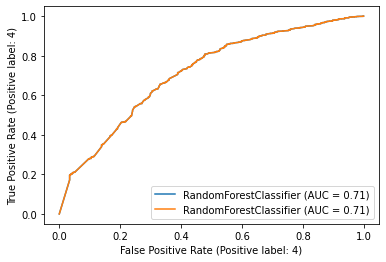

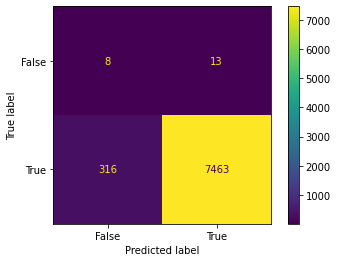

KNeighborsClassifier  Accuracy Score : 95.74%
              precision    recall  f1-score   support

           0       0.01      0.17      0.01        12
           4       1.00      0.96      0.98      7788

    accuracy                           0.96      7800
   macro avg       0.50      0.56      0.50      7800
weighted avg       1.00      0.96      0.98      7800



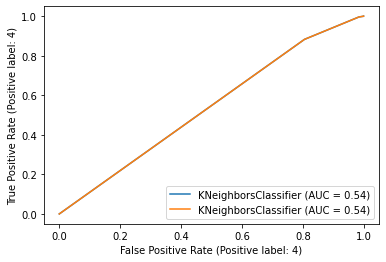

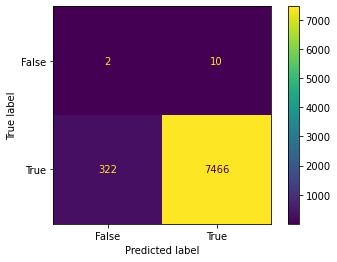

XGBClassifier  Accuracy Score : 95.69%
              precision    recall  f1-score   support

           0       0.06      0.38      0.10        48
           4       1.00      0.96      0.98      7752

    accuracy                           0.96      7800
   macro avg       0.53      0.67      0.54      7800
weighted avg       0.99      0.96      0.97      7800



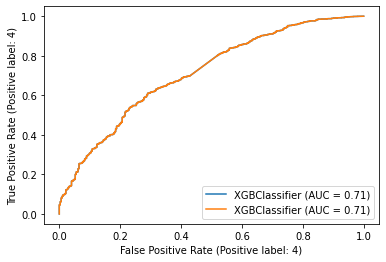

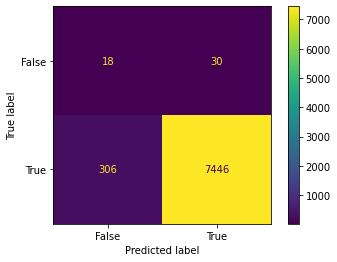

AdaBoostClassifier  Accuracy Score : 95.45%
              precision    recall  f1-score   support

           0       0.02      0.17      0.04        47
           4       0.99      0.96      0.98      7753

    accuracy                           0.95      7800
   macro avg       0.51      0.56      0.51      7800
weighted avg       0.99      0.95      0.97      7800



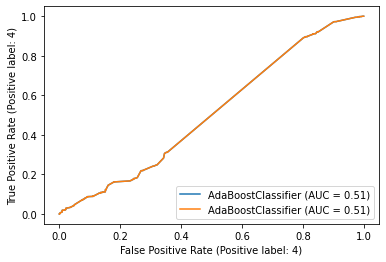

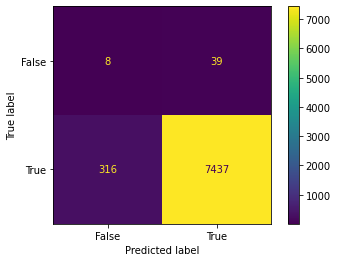

Support Vector Machine  Accuracy Score : 95.86%
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           4       1.00      0.96      0.98      7799

    accuracy                           0.96      7800
   macro avg       0.50      0.98      0.49      7800
weighted avg       1.00      0.96      0.98      7800



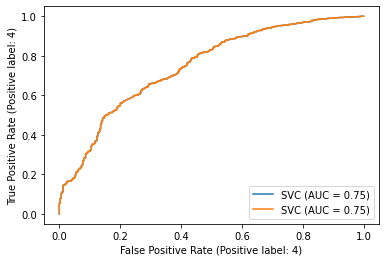

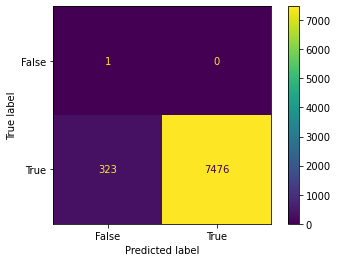

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
lbl_actual = test_df.target
i = 0
accuracy = []
for cl in cls:
    model = cl.fit(train_tfidf_model,train_df.target)
    lbl_pred = model.predict(test_tfidf_model)
    a = (100*accuracy_score(lbl_pred, lbl_actual))
    a = round(a,2)
    accuracy.append(a)
    disp=plot_roc_curve(cl,test_tfidf_model,test_df.target)
    plot_roc_curve(cl, test_tfidf_model,test_df.target,ax=disp.ax_ )
    print ("{}  Accuracy Score : {}%".format(cls_name[i],a))
    print ( classification_report(lbl_pred, lbl_actual)) 
    confusion_matrix = metrics.confusion_matrix(lbl_pred, lbl_actual)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show() 
    i +=1

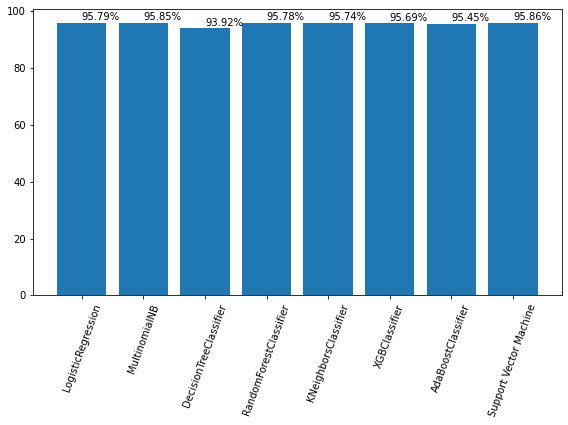

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(cls_name, accuracy)
plt.xticks(rotation=70)
for index,data in enumerate(accuracy):
    plt.text(x=index , y =data+1 , s=f"{data}%" , fontdict=dict(fontsize=10))
plt.tight_layout()
plt.show()